In [1]:
#!/usr/bin/python

# Import required modules
import os
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mpltkr
import matplotlib.colors as mplcolors
import matplotlib.patches as mplpatches
import matplotlib.lines as mpllines
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Utilities
import project_utils as utils
import h5py

# Import COSMO style toolkit
import cosmoplot.colorbars as cosmocbars
import cosmoplot.utils as cosmoutils
import cosmoplot.style as cosmostyle

cosmostyle.set_style('article')
color_list = cosmostyle.color_cycle

# PCA on structures

In [2]:
deem_dir = '../../Processed_Data/DEEM_330k'
iza_dir = '../../Processed_Data/IZA_226'
data_dir = 'Data/6.0/Linear_Models/PCA'

In [3]:
# Load Deem 10k PCA
deem_10k_idxs = np.loadtxt('../../Processed_Data/DEEM_330k/deem_10k.idxs', dtype=int)
deem_pca = utils.load_hdf5(f'{deem_dir}/{data_dir}/pca_structures.hdf5')

# Load IZA PCA
iza_pca = utils.load_hdf5(f'{iza_dir}/{data_dir}/pca_structures.hdf5', 
                          datasets=None, indices=None, concatenate=True)
cantons = np.loadtxt('../../Raw_Data/GULP/IZA_226/cantons.txt', usecols=1, dtype=int)
n_iza = len(cantons)

In [4]:
iza_delete = np.nonzero(cantons == 4)[0]
deem_delete = np.loadtxt('../../Processed_Data/DEEM_330k/10kJmol_error.idxs', dtype=int)

In [5]:
# Structure energies
deem_330k_energies = np.loadtxt('../../Raw_Data/GULP/DEEM_330k.bk/optimization_summary_fix.dat', usecols=2)
deem_330k_energies = np.delete(deem_330k_energies, deem_delete)

# TODO: change this when IZA re-optimized
iza_energies = np.loadtxt('../../Processed_Data/IZA_226/Data/structure_energies.dat')
#iza_energies = np.delete(iza_energies, iza_delete)

energies = np.concatenate((iza_energies, deem_330k_energies))

In [6]:
# Structure volumes
deem_330k_volumes = np.loadtxt('../../Processed_Data/DEEM_330k/Data/structure_volumes.dat')
deem_330k_volumes = np.delete(deem_330k_volumes, deem_delete)

iza_volumes = np.loadtxt('../../Processed_Data/IZA_226/Data/structure_volumes.dat')
#iza_volumes = np.delete(iza_energies, iza_delete)

volumes = np.concatenate((iza_volumes, deem_330k_volumes))

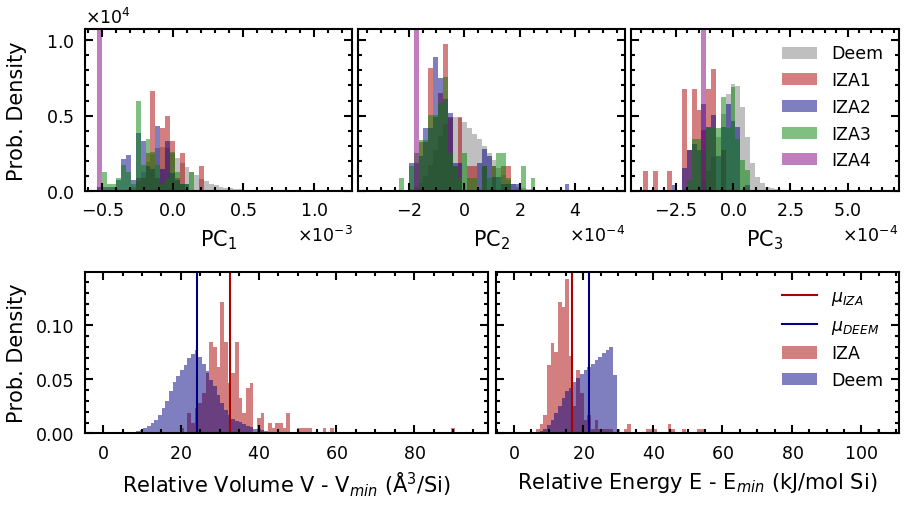

In [9]:
# Histogram of PCA values

# PCA HISTOGRAM
n_pca = 3
fig = plt.figure(figsize=(7.0, 3.5))
gs = fig.add_gridspec(nrows=2, ncols=1, hspace=0.50)

pca_gs = gs[0].subgridspec(1, n_pca, wspace=0.02)
pca_axes = [fig.add_subplot(pca_gs[i]) for i in range(0, n_pca)]
pca_grouper = pca_axes[0].get_shared_y_axes()
for ax in pca_axes[1:]:
    pca_grouper.join(ax, pca_axes[0])
    ax.tick_params(labelleft=False)

hist_gs = gs[1].subgridspec(1, 2, wspace=0.02)
axs_volume = fig.add_subplot(hist_gs[0])
axs_energy = fig.add_subplot(hist_gs[1])
hist_grouper = axs_energy.get_shared_y_axes()
hist_grouper.join(axs_energy, axs_volume)
axs_energy.tick_params(labelleft=False)

histogram_max = np.amax(np.vstack((iza_pca, deem_pca)), axis=0)
histogram_min = np.amin(np.vstack((iza_pca, deem_pca)), axis=0)
histogram_parameters = dict(bins=50, density=True, log=False, alpha=0.5)

h_max = 0.0
for pc, axs in enumerate(pca_axes):
    histogram_range = (histogram_min[pc], histogram_max[pc])
    
    h_deem, bins_deem, _ = axs.hist(
        deem_pca[:, pc], range=histogram_range, 
        **histogram_parameters, color=color_list[5], label='Deem'
    )
    
    for i in range(1, np.amax(cantons)+1):
        canton_idxs = np.nonzero(cantons == i)[0]
        
        h_iza, bins_iza, _ = axs.hist(
            iza_pca[canton_idxs, pc], range=histogram_range, 
            **histogram_parameters, color=color_list[i], label=f'IZA{i}'
        )
        
        if i < 4:
            h_max = np.maximum(h_max, np.amax(np.concatenate((h_deem, h_iza))))
      
    axs.ticklabel_format(axis='both', style='scientific', scilimits=(0, 0), useMathText=True)
    
    if pc == 0:
        axs.set_ylabel('Prob. Density')
    else:
        offset_txt = axs.get_yaxis().get_offset_text().set_visible(False)
        
    axs.set_xlabel(fr'PC$_{{{pc+1}}}$')

pca_axes[-1].legend()

yscale = 0.10
for axs in pca_axes:
    axs.set_ylim([0.0, h_max+yscale*h_max])

# VOLUME HISTOGRAM
volume_histogram_parameters = dict(
    #range=(np.amin(energies), np.amax(energies)), 
    range=(0.0, np.amax(volumes)-np.amin(volumes)), 
    density=True, bins=100, log=False, alpha=0.5
)

axs_volume.hist(volumes[0:n_iza]-np.amin(volumes), **volume_histogram_parameters, facecolor=color_list[1])
axs_volume.axvline(np.mean(volumes[0:n_iza]-np.amin(volumes)), color=color_list[1], label=r'$\mu_{IZA}$')

axs_volume.hist(volumes[n_iza:]-np.amin(volumes), **volume_histogram_parameters, facecolor=color_list[2])
axs_volume.axvline(np.mean(volumes[n_iza:]-np.amin(volumes)), color=color_list[2], label=r'$\mu_{DEEM}$')

axs_volume.set_ylabel('Prob. Density')
axs_volume.set_xlabel(r'Relative Volume V - V$_{min}$ ' + u'(\u00c5' + r'$^3$/Si)')
axs_volume.ticklabel_format(axis='x', style='plain', scilimits=(0, 0), useMathText=True)

#axs_volume.legend(fontsize='large')

# ENERGY HISTOGRAM
energy_histogram_parameters = dict(
    #range=(np.amin(energies), np.amax(energies)), 
    range=(0.0, np.amax(energies)-np.amin(energies)), 
    density=True, bins=100, log=False, alpha=0.5
)

axs_energy.hist(energies[0:n_iza]-np.amin(energies), **energy_histogram_parameters, facecolor=color_list[1], label='IZA')
axs_energy.axvline(np.mean(energies[0:n_iza]-np.amin(energies)), color=color_list[1], label=r'$\mu_{IZA}$')

axs_energy.hist(energies[n_iza:]-np.amin(energies), **energy_histogram_parameters, facecolor=color_list[2], label='Deem')
axs_energy.axvline(np.mean(energies[n_iza:]-np.amin(energies)), color=color_list[2], label=r'$\mu_{DEEM}$')

axs_energy.set_xlabel(r'Relative Energy E - E$_{min}$ (kJ/mol Si)')
axs_energy.ticklabel_format(axis='x', style='plain', scilimits=(0, 0), useMathText=True)

axs_energy.legend()

fig.align_ylabels()

fig.savefig('../../Results/6.0/pca_histogram_6.0.pdf', bbox_inches='tight')

plt.show()

In [ ]:
# Camera view settings
x = -1.25
y = -1.25
z = 0.50

# Compute aspect ratio from data
# so we can set it manually including zoom
zoom = 2.4
aspect_ratio_keys = ['x', 'y', 'z']
xyz_max = np.amax(np.vstack((deem_pca[:, 0:3], iza_pca[:, 0:3])), axis=0)
xyz_min = np.amin(np.vstack((deem_pca[:, 0:3], iza_pca[:, 0:3])), axis=0)
xyz_ratios = np.abs(xyz_max - xyz_min)
xyz_ratios = xyz_ratios / xyz_ratios[0] * zoom

aspect_ratio = {key: value for key, value in zip(aspect_ratio_keys, xyz_ratios)}

In [ ]:
# 3D scatter
# TODO: with full 330k?
fig = make_subplots(
    rows=3, cols=3,
    column_widths=[1.0, 1.0, 1.0],
    row_heights=[1.0, 1.0, 1.0],
    horizontal_spacing=0.10,
    specs=[
        [{'type': 'scene', 'rowspan': 2, 'colspan': 3, 'b': 0.0}, None, None],
        [None, None, None],
        [{'type': 'xy'}, {'type': 'xy'}, {'type': 'xy'}]
    ]
)

## Deem
fig.add_trace(
    go.Scatter3d(
        x=deem_pca[:, 0], 
        y=deem_pca[:, 1], 
        z=deem_pca[:, 2],
        mode='markers', 
        marker=dict(color=color_list[9], size=1),
        name='DEEM'
    ),
    row=1, col=1
)

## IZA
for i in range(1, np.amax(cantons) + 1):
    iza_pts = np.nonzero(cantons == i)[0]
    fig.add_trace(
        go.Scatter3d(
            x=iza_pca[iza_pts, 0], 
            y=iza_pca[iza_pts, 1], 
            z=iza_pca[iza_pts, 2],
            mode='markers', 
            marker=dict(color=color_list[i], size=2),
            name=f'IZA{i}'
        ),
        row=1, col=1
    )
    
## Format the 3D scatter
fig.update_scenes(
    xaxis=dict(
        title='PC<sub>1</sub>',
        showgrid=True,
        linewidth=2,
        ticks='',#'inside',
        mirror=True,#'ticks',
        showexponent='all',
        exponentformat='power',
        #minexponent=0
        showticklabels=False
    ),
    yaxis=dict(
        title='PC<sub>2</sub>',
        showgrid=True,
        linewidth=2,
        ticks='',#'inside',
        mirror=True,#'ticks',
        showexponent='all',
        exponentformat='power',
        #minexponent=0
        showticklabels=False
    ),
    zaxis=dict(
        title='PC<sub>3</sub>',
        showgrid=True,
        linewidth=2,
        ticks='',#'inside',
        mirror=True,#'ticks',
        showexponent='all',
        exponentformat='power',
        #minexponent=0
        showticklabels=False
    ),
    camera=dict(
        eye=dict(x=x, y=x, z=z),
        projection=dict(type='orthographic')
    ),
    aspectratio=aspect_ratio,
    row=1, col=1
)
    
# 2D subplots
col_idx = 1
for i in range(0, 3):
    for j in range(i+1, 3):
        
        ## Deem
        fig.add_trace(
            go.Scattergl(
                x=deem_pca[:, i],
                y=deem_pca[:, j],
                mode='markers',
                marker=dict(color=color_list[9], size=2),
                name='DEEM',
                showlegend=False
            ),
            row=3, col=col_idx
        )
        
        ## IZA
        for k in range(1, np.amax(cantons) + 1):
            iza_pts = np.nonzero(cantons == k)[0]
            fig.add_trace(
                go.Scattergl(
                    x=iza_pca[iza_pts, i],
                    y=iza_pca[iza_pts, j],
                    mode='markers',
                    marker=dict(color=color_list[k], size=4),
                    name=f'IZA{k}',
                    showlegend=False
                ),
                row=3, col=col_idx
            )
            
        ## Format the 2D scatter
        fig.update_xaxes(
            title_text=f'PC<sub>{i+1}</sub>',
            showline=True,
            linewidth=2,
            mirror=True,#'ticks',
            #showgrid=True,
            ticks='',#'inside',
            showexponent='all',
            exponentformat='power',
            #minexponent=0,
            showticklabels=False,
            row=3, col=col_idx
        )
        fig.update_yaxes(
            title_text=f'PC<sub>{j+1}</sub>',
            showline=True,
            linewidth=2,
            mirror=True,#'ticks',
            #showgrid=True,
            ticks='',#'inside',
            showexponent='all',
            exponentformat='power',
            #minexponent=0,
            showticklabels=False,
            row=3, col=col_idx
        )
        
        col_idx += 1

# Global layout setup
fig.update_layout(
    template='simple_white',
    legend=dict(
        x=1.0, 
        y=1.0,
        xanchor='left', 
        yanchor='top',
        itemsizing='constant'
    ),
    font=dict(size=16,
              family='Serif'),
    autosize=False,
    width=800, height=800,
    margin=dict(l=0, b=50, t=0, r=0)
)

# Save and show figure
fig.write_html('../../Results/6.0/pca_6.0.html')
fig.write_image('../../Results/6.0/pca_6.0.pdf')
fig.show()